## Brief Introduction
In this notebook, I implemented PCA only on the Normal data, and then implement the Anomaly Detection with both the Gaussian and Reconstruction Methods.  

The anomaly in the datast is a figure with mustache.

Data Source: http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random
from random import shuffle

from support_functions import *

## Read in Images and Remove Over-shadowed Ones

In [2]:
# Define the images to be read and the corresponding labels
label_1_folder = [9,21]
target_folders = range(1,22)
data_path = "Yale Face B/CroppedYale/"

# We also need to reduce the size of the image for the convenience of computation
reduce_height = 24
reduce_width = 21

# Read the images and reduce the size
images,labels = read_images(data_path,target_folders,label_1_folder,reduce_height,reduce_width)

# Number of labels as "Anomaly" and Total Number of Labels
sum(labels),len(labels)

(126, 1243)

574  images are above our threshold and thus removed from the list


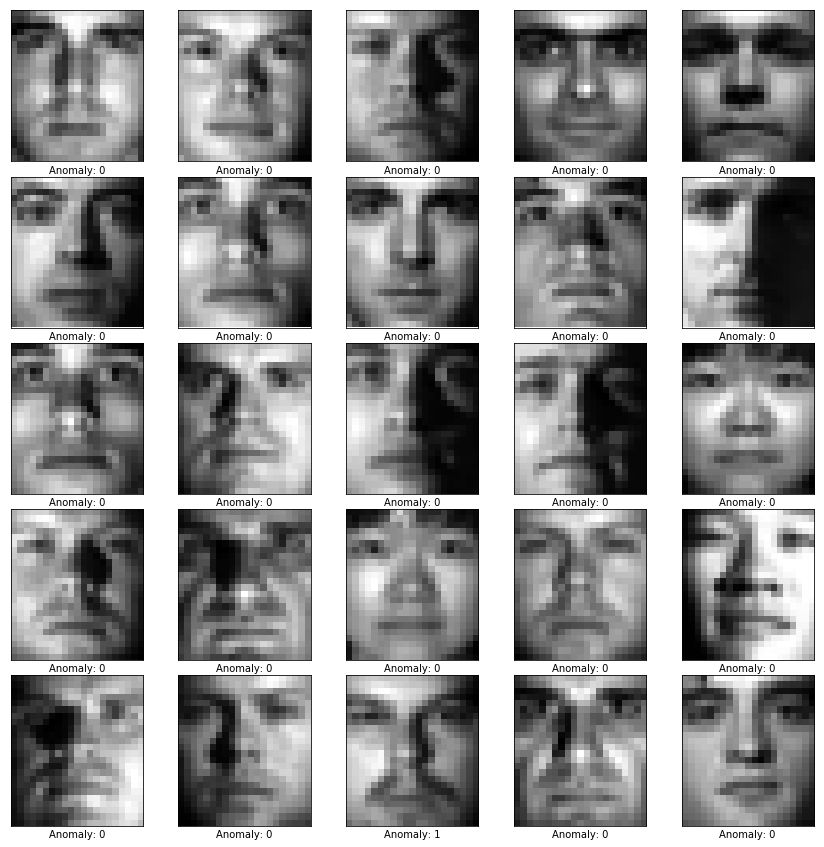

In [3]:
# To evaluate the threshold of the dark pixels
# dark_pixel_curve(images)

imgs = images[:] # Create a copy
# Eliminate the images and labels whose number of dark pixels are above the threshold
# The threshold is determined based on the dark_pixel_curve() function above
imgs,labels,remove_count = remove_dark_img(imgs,labels,180) 

plot_images(imgs,labels)

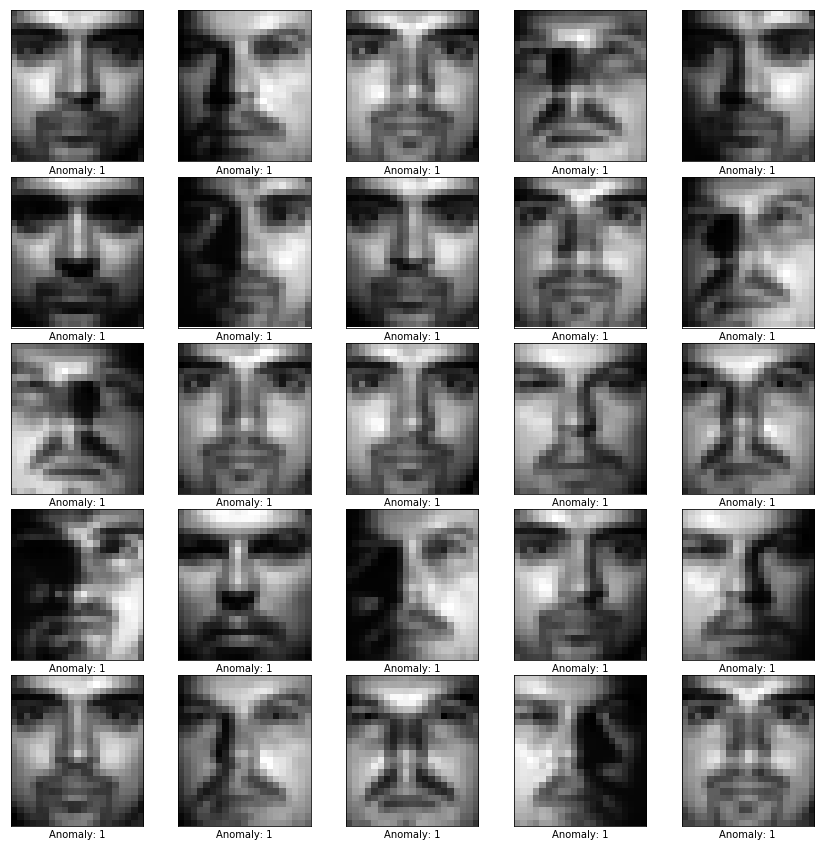

In [4]:
# Randomly select and show anomalous images
show_anomaly_images(imgs,labels)

## Apply PCA on the Normal Images for Dimension Reduction

In [5]:
# Define the number of Principal Components to keep from the image
n_components  = 20

# Find the dimension of one image
height, width = imgs[0].shape
num_imgs = len(imgs)
height, width,num_imgs

(24, 21, 669)

### Convert the Images List to a 2-Dimensional Matrix
Convert each image from 2D to 1D array, and each column of the new matrix will be one image.

In [6]:
# Initialize the matrix to store the entire image list
imgs_matrix = np.zeros((height*width,num_imgs)) 

# Iterate through each image, convert it into an array, and add to the imgs_matrix as a column
for i in range(0,len(imgs)):
    imgs_matrix[:,i] = imgs[i].reshape(height*width)
imgs_matrix.shape

(504, 669)

### Isolate the Normal Image Dataset

In [7]:
# Vectorize the labels list
labels_vector = np.hstack(labels) # Easier to get multiple items from a vector than from a list

# Select only the Normal Image Dataset
imgs_matrix_normal = imgs_matrix[:,labels_vector == 0]
imgs_matrix_normal.shape

(504, 605)

### Take a Mean-Shift - *With only the Normal Data*
We applied the Mean-Shift on each component before computing the Covariance Matrix. It is important to save the vector of the components' mean: we will use it when we reconstruct the data after we applied PCA.

In [8]:
img_matrix_shifted_normal, component_mean_normal = mean_shift(imgs_matrix_normal)

### Compute the Covariance Matrix of the Image Matrix - *With only the Normal Data*
The Covariance Matrix should be a symmetric square matrix with shape  $n∗n$, where $n$ is the row number of the Image Matrix, or the number of the components.

In [9]:
cov_matrix = np.cov(img_matrix_shifted_normal)
cov_matrix.shape

(504, 504)

### Compute the eigenvectors and the corresponding eigenvalues - *With only the Normal Data*

In [10]:
# Compute the eigen value and eigen vectors
eigen_value, eigen_vector = np.linalg.eig(cov_matrix)

# Sort the eigenvectors by decreasing eigenvalues
# First make a list of (eigenvalue, eigenvector) tuples 
eig_pairs = [(np.abs(eigen_value[i]), eigen_vector[:,i]) for i in range(len(eigen_value))] 
# Sort the (eigenvalue, eigenvector) tuples from high to low 
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Convert the sorted eigen vector list to matrix form
eigen_vector_sorted = np.zeros((height*width,n_components))
for i in range(0,n_components):
    eigen_vector_sorted[:,i] = eig_pairs[i][1]

### Compute the PCA Matrix and Visualize the Eigenfaces - *With only the Normal Data*

In [11]:
# Cut the sorted eigenvectors by columns to get the transformational matrix for PCA
pca_matrix = eigen_vector_sorted[:,:n_components]
pca_matrix.shape

(504, 20)

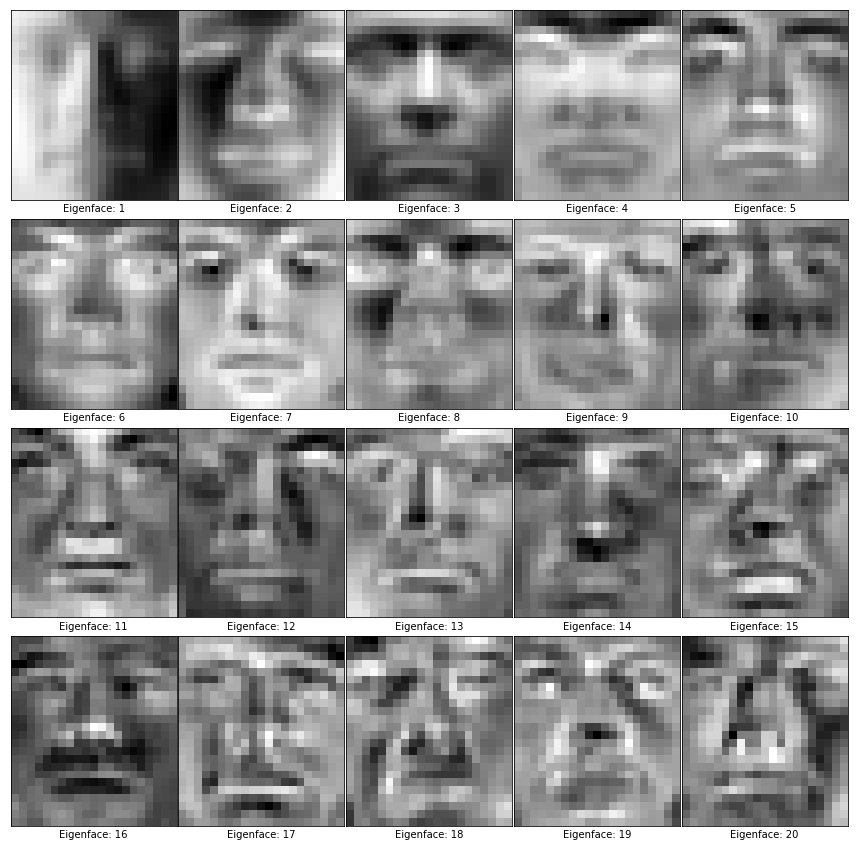

In [12]:
# Visualize the eigenfaces with the pca matrix
plot_eigenfaces(pca_matrix,height, width)

### Reconstruct the Face Images after PCA - *With only the Normal Data*
First we applies PCA on the image data matrix to downsize its dimensions. Then we reconstruct the image matrix through the PCA matrix and add the mean of each component back. Finally we plot several examples to compare the original face images with the reconstructed face images.

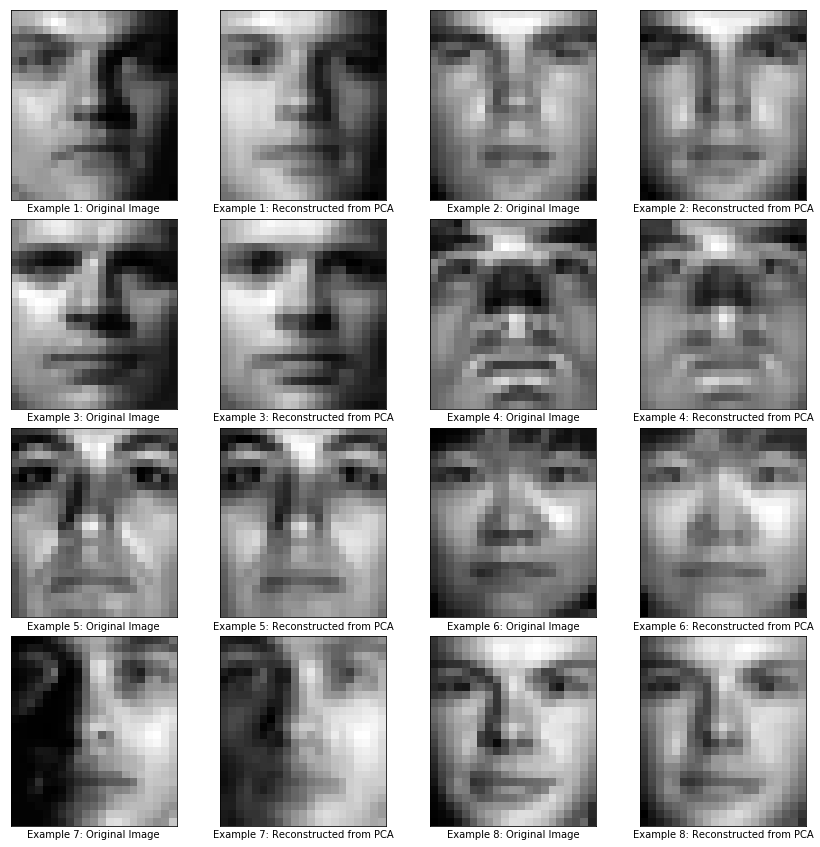

In [13]:
# Compute the transformed image
# Shape of pca_matrix: n * k
# Shape of imgs_matrix: n * m
# Shape of the transformed face image matrix: k * m
img_pca_tranf_normal = pca_matrix.T.dot(img_matrix_shifted_normal)

# Reconstruct through PCA Matrix and Mean Vector
# Shape of the reconstructed face image matrix: n * m
# component_mean is a vector and we need to convert it to a one-column matrix for the addition
img_matrix_reconst_normal = pca_matrix.dot(img_pca_tranf_normal) + component_mean_normal.reshape(height*width,1)

# Plot the original images and their reconstructed version for comparison
plot_compare_after_reconst(img_matrix_reconst_normal,imgs_matrix_normal,height,width)

## Anomaly Detection with Multivariate Gaussian Method

### Apply PCA Matrix on All the Data (Normal and Anomalous)
Use the PCA Matrix generated from only the Normal Dataset

In [14]:
# Mean Shift
img_matrix_shifted_all, component_mean_all = mean_shift(imgs_matrix)

# Compute the transformed image
# Shape of pca_matrix: n * k
# Shape of imgs_matrix: n * m
# Shape of the transformed face image matrix: k * m
img_pca_tranf_all = pca_matrix.T.dot(img_matrix_shifted_all)

### Split the Data into the Training and Validation Set¶
With the function, we get the indice of images to be assigned to the training and the validation set

In [15]:
# Split the images and labels
ratio_train = 0.6 # 60% of the images will be splitted to the training set
ratio_val = 0.3
train_ind, val_ind, test_ind = split_train_eval_test(labels_vector,ratio_train,ratio_val)

imgs_train = img_pca_tranf_all[:,train_ind]
imgs_val = img_pca_tranf_all[:,val_ind]
imgs_test = img_pca_tranf_all[:,test_ind]
labels_train = labels_vector[train_ind]
labels_val = labels_vector[val_ind]
labels_test = labels_vector[test_ind]

imgs_train.shape, imgs_val.shape,imgs_test.shape, labels_train.shape,labels_val.shape,labels_test.shape

((20, 401), (20, 200), (20, 68), (401,), (200,), (68,))

### Training

In [16]:
# Get Gaussian Distribution Model for the Training Data (all Normal) 
# Note: fit_multivariate_gaussian() is my own coded function
dist = fit_multivariate_gaussian(imgs_train.T)
# dist = fit_multivariate_gaussian(img_pca_tranf_all.T)

# Get Probability of being Anomaly vs. being Normal
p_val = dist.pdf(imgs_val.T)   # Probability of Being Normal

# Train the Anomaly Detector
threshold  = select_threshold(p_val, labels_val)
p_val = dist.pdf(imgs_val.T)   # Probability of Being Normal
preds = p_val < threshold
tpr,tnr,fpr,fnr,f1 = eval_prediction(preds,labels_val,rate = True)
tpr,tnr,fpr,fnr,f1

(0.97872340425531912,
 0.13725490196078433,
 0.86274509803921573,
 0.021276595744680851,
 0.40888888888888886)

### Testing

In [17]:
p_test = dist.pdf(imgs_test.T)   # Probability of Being Normal
preds = p_test < threshold
tpr,tnr,fpr,fnr,f1 = eval_prediction(preds,labels_test,rate = True)
tpr,tnr,fpr,fnr,f1

(0.94117647058823528,
 0.17647058823529413,
 0.82352941176470584,
 0.058823529411764705,
 0.42666666666666669)

## Anomaly Detection with PCA Reconstruction Error
The method will measure the Euclidean distance between each data point on the image and its new point after reconstruction from the PCA. The basis of this method is that the Anomalies will give large values of distance. I will use the training data to fit the distribution, and validation data to find the optimal threshold to identify the Anomalies.

### Training

In [18]:
# Reconstruct from PCA
# Shape of the reconstructed face image matrix: n * m
# component_mean is a vector and we need to convert it to a one-column matrix for the addition
img_matrix_reconst_all = pca_matrix.dot(img_pca_tranf_all) + component_mean_all.reshape(height*width,1)

# Find the euclidean distance between the reconstructed dataset and the original ()
dist = find_euclidean_distance(img_matrix_reconst_all,imgs_matrix)
np.min(dist),np.mean(dist),np.max(dist)

(119.18758226810959, 257.97624155033975, 640.13638287682932)

In [19]:
# Fit the Distribution with the Training Data (All Normal)
dist_val= dist[val_ind]
# Find the optimal Threshold with the Validation Data
threshold2, tpr,tnr,fpr,fnr,f1 = select_threshold_distance(dist_val, labels_val)
tpr,tnr,fpr,fnr,f1

(0.91489361702127658,
 0.83660130718954251,
 0.16339869281045752,
 0.085106382978723402,
 0.74782608695652175)

### Testing

In [20]:
dist_test= dist[test_ind]
preds_test2 = dist_test > threshold2
tpr,tnr,fpr,fnr,f1 = eval_prediction(preds_test2,labels_test,rate = True)
tpr,tnr,fpr,fnr,f1

(0.82352941176470584,
 0.72549019607843135,
 0.27450980392156865,
 0.17647058823529413,
 0.62222222222222223)

## Anomaly Detection with Local Outlier Factor Method

In [21]:
input_matrix = img_pca_tranf_all.T
from sklearn.neighbors import LocalOutlierFactor

# fit the model with k = 20 neighbours (default value)
clf = LocalOutlierFactor(n_neighbors=20)
# Input all the data (Normal Training and Outliers) to the LOF Model
y_pred = clf.fit_predict(input_matrix) # Labels: 1 indicates normal, and -1 indicates outliers
# Convert the pred into the standard format: 1 indicates Anomaly, and 0 indicates Normal
y_pred_convert = convert_pred(y_pred,label_Anomaly = -1,label_Normal = 1) 
Recall, Precision, F = evaluate_pred(y_pred_convert, labels_vector)
Recall, Precision, F

(0.015625, 0.014925373134328358, 0.00046641791044776119)